##Monet Style Art Painitng using GAN (CycleGAN)

**Project Description:**

Monet Style art Painitng  is a powerful computer vision technique that involves reconstructing missing or damaged parts of an image. The goal of this project is to explore and implement an Monet Style Art painitng using CycleGAN (Cycle-Consistent Generative Adversarial Network), a state-of-the-art approach in the field of image-to-image translation.




**Importing dependencies**

In [ ]:
# Importing required libraries
import os
import cv2
import torch
import random
import torch
import numpy as np
import tensorflow as tf
import skimage.metrics as skm
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from pathlib import Path

In [ ]:
def check_gpu_availability():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available.")
        print("GPU Device Name:", torch.cuda.get_device_name(0))  # 0 indicates the first GPU device
        print("CUDA Version:", torch.version.cuda)
    else:
        device = torch.device("cpu")
        print("GPU is not available. Using CPU for computations.")
    return device

In [ ]:
device = check_gpu_availability()

GPU is available.
GPU Device Name: Tesla T4
CUDA Version: 11.8


**Loading Datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading monet and photo directories for EDA
monet_eda = "/content/drive/MyDrive/monet_jpg"
photo_eda = "/content/drive/MyDrive/photo_jpg"

In [ ]:
def get_image_paths(directory_path, extensions=[".jpg", ".jpeg", ".png", ".gif", ".bmp"]):
    """
    Get a list of image file paths from a directory.

    Parameters:
        directory_path (str): The path to the directory containing the images.
        extensions (list): A list of file extensions to consider as image files. Default: [".jpg", ".jpeg", ".png", ".gif", ".bmp"]

    Returns:
        List of image file paths.
    """
    image_paths = []
    directory_path = Path(directory_path)

    if not directory_path.is_dir():
        raise ValueError("The provided directory path does not exist.")

    for file_path in directory_path.iterdir():
        if file_path.is_file() and file_path.suffix.lower() in extensions:
            image_paths.append(str(file_path))

    return image_paths


In [ ]:
monet= get_image_paths(monet_eda)
photo= get_image_paths(photo_eda)

**Exploratory Data Analysis**

In [ ]:
# Viewing number of images in monet and photo datasets
print("Monet Images: ", len(monet))
print("Photo Images: ", len(photo))

Monet Images:  300
Photo Images:  7057


In [ ]:
def visualize_sample_images(image_paths, num_samples=5, random_seed=None):
    """
    Visualize a random sample of images from the provided list of image paths.

    Parameters:
        image_paths (list): List of image file paths.
        num_samples (int): Number of images to visualize. Default: 5.
        random_seed (int): Seed value for reproducibility. Default: None.

    Returns:
        None
    """
    if random_seed is not None:
        random.seed(random_seed)

    # Randomly select 'num_samples' image paths
    sample_paths = random.sample(image_paths, num_samples)

    plt.figure(figsize=(15, 6))
    for i, image_path in enumerate(sample_paths):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()




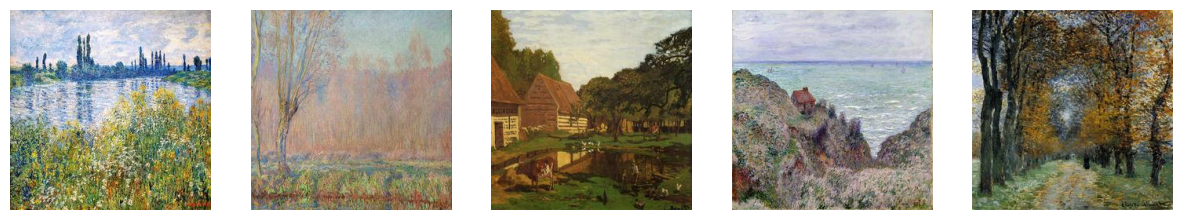

In [ ]:
visualize_sample_images(monet)

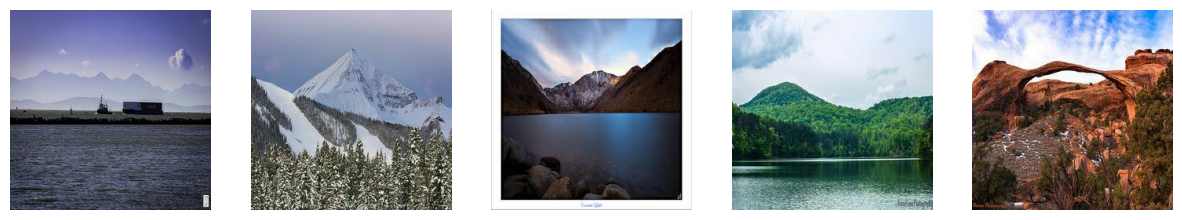

In [ ]:
visualize_sample_images(photo)

**Defining Training Parameters**

In [ ]:
# Define training parameters
EPOCHS = 100
BATCH_SIZE = 2



**Architecture of Cycle GAN**

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    """
    Create a downsampling layer using strided convolution.

    Parameters:
        filters (int): Number of filters in the convolutional layer.
        size (int): Size of the convolutional filter.
        apply_batchnorm (bool): Whether to apply batch normalization. Default: True.

    Returns:
        Downsampled layer with the specified configuration.
    """
    initializer = tf.random_normal_initializer(0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters, size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result



In [ ]:
def upsample(filters, size, apply_dropout=False):
    """
    Create an upsampling layer using transposed convolution.

    Parameters:
        filters (int): Number of filters in the transposed convolutional layer.
        size (int): Size of the transposed convolutional filter.
        apply_dropout (bool): Whether to apply dropout. Default: False.

    Returns:
        Upsampled layer with the specified configuration.
    """
    initializer = tf.random_normal_initializer(0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result




In [ ]:
def generator_model(output_channels=3):
    """
    Create the Generator model for CycleGAN.

    Parameters:
        output_channels (int): Number of output channels (typically 3 for RGB images). Default: 3.

    Returns:
        Generator model.
    """
    inputs = tf.keras.layers.Input(shape=[256, 256, output_channels])

    # Downsampling layers
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    # Upsampling layers
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 4, strides=2, padding="same", kernel_initializer=initializer, activation="tanh"
    )  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # last skip connection is the start of the upsampling

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)



In [ ]:
def discriminator_model():
    """
    Create the Discriminator model for CycleGAN.

    Returns:
        Discriminator model.
    """
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])  # Input shape for RGB images

    initializer = tf.random_normal_initializer(0, 0.02)

    # Downsampling layers
    down1 = downsample(64, 4, apply_batchnorm=False)(inputs)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer, use_bias=False
    )(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1, kernel_initializer=initializer
    )(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=inputs, outputs=last)




In [ ]:
class CycleGAN(tf.keras.Model):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.generator_monet_to_photo = generator_model(output_channels=3)
        self.generator_photo_to_monet = generator_model(output_channels=3)
        self.discriminator_monet = discriminator_model()
        self.discriminator_photo = discriminator_model()
               # Initialize optimizers for each part of the model
        self.gen_monet_to_photo_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
        self.gen_photo_to_monet_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
        self.disc_monet_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
        self.disc_photo_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

    def compile(self, gen_monet_to_photo_optimizer, gen_photo_to_monet_optimizer,
                disc_monet_optimizer, disc_photo_optimizer, gen_loss_fn, disc_loss_fn):
        super(CycleGAN, self).compile()
        self.gen_monet_to_photo_optimizer = gen_monet_to_photo_optimizer
        self.gen_photo_to_monet_optimizer = gen_photo_to_monet_optimizer
        self.disc_monet_optimizer = disc_monet_optimizer
        self.disc_photo_optimizer = disc_photo_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn

    def generate_monet_to_photo(self, image):
        return self.generator_monet_to_photo(image)

    def generate_photo_to_monet(self, image):
        return self.generator_photo_to_monet(image)

    def discriminate_monet(self, image):
        return self.discriminator_monet(image)

    def discriminate_photo(self, image):
        return self.discriminator_photo(image)

    def gradient_penalty(self, real, fake, batch_size):
        epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated_image = real + epsilon * (fake - real)
        with tf.GradientTape() as tape:
            tape.watch(interpolated_image)
            pred = self.discriminate_photo(interpolated_image)
        grad = tape.gradient(pred, interpolated_image)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_monet, real_photo = data

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images for both directions
            fake_photo = self.generate_monet_to_photo(real_monet)
            fake_monet = self.generate_photo_to_monet(real_photo)

            # Generate cycled images (reconstructed)
            cycled_monet = self.generate_photo_to_monet(fake_photo)
            cycled_photo = self.generate_monet_to_photo(fake_monet)

            # Identity mapping
            same_monet = self.generate_photo_to_monet(real_monet)
            same_photo = self.generate_monet_to_photo(real_photo)

            # Discriminator outputs
            disc_real_monet = self.discriminate_monet(real_monet)
            disc_real_photo = self.discriminate_photo(real_photo)
            disc_fake_monet = self.discriminate_monet(fake_monet)
            disc_fake_photo = self.discriminate_photo(fake_photo)

            # Generator and Discriminator losses
            gen_monet_to_photo_loss = generator_adversarial_loss(disc_fake_photo)
            gen_photo_to_monet_loss = generator_adversarial_loss(disc_fake_monet)

            total_cycle_loss = cycle_consistency_loss(real_monet, cycled_monet) + cycle_consistency_loss(real_photo, cycled_photo)

            identity_loss_monet = identity_loss(real_monet, same_monet)
            identity_loss_photo = identity_loss(real_photo, same_photo)

            disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
            disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

            # Gradient penalty for WGAN-GP
            gp_monet = self.gradient_penalty(real_monet, fake_monet, batch_size=BATCH_SIZE)
            gp_photo = self.gradient_penalty(real_photo, fake_photo, batch_size=BATCH_SIZE)

            disc_monet_loss += 10.0 * gp_monet
            disc_photo_loss += 10.0 * gp_photo

            # Total Generator and Discriminator loss
            total_gen_monet_to_photo_loss = total_generator_loss(gen_monet_to_photo_loss, total_cycle_loss, identity_loss_photo)
            total_gen_photo_to_monet_loss = total_generator_loss(gen_photo_to_monet_loss, total_cycle_loss, identity_loss_monet)

        # Calculate gradients for each part of the model
        gen_monet_to_photo_gradients = tape.gradient(total_gen_monet_to_photo_loss,
                                                         self.generator_monet_to_photo.trainable_variables)
        gen_photo_to_monet_gradients = tape.gradient(total_gen_photo_to_monet_loss,
                                                         self.generator_photo_to_monet.trainable_variables)

        disc_monet_gradients = tape.gradient(disc_monet_loss, self.discriminator_monet.trainable_variables)
        disc_photo_gradients = tape.gradient(disc_photo_loss, self.discriminator_photo.trainable_variables)

            # Update generators and discriminators using respective optimizers
        self.gen_monet_to_photo_optimizer.apply_gradients(
                zip(gen_monet_to_photo_gradients, self.generator_monet_to_photo.trainable_variables)
            )
        self.gen_photo_to_monet_optimizer.apply_gradients(
                zip(gen_photo_to_monet_gradients, self.generator_photo_to_monet.trainable_variables)
            )

        self.disc_monet_optimizer.apply_gradients(
                zip(disc_monet_gradients, self.discriminator_monet.trainable_variables)
            )
        self.disc_photo_optimizer.apply_gradients(
                zip(disc_photo_gradients, self.discriminator_photo.trainable_variables)
            )


        return {
            "gen_monet_to_photo_loss": total_gen_monet_to_photo_loss,
            "gen_photo_to_monet_loss": total_gen_photo_to_monet_loss,
            "disc_monet_loss": disc_monet_loss,
            "disc_photo_loss": disc_photo_loss,
        }


In [ ]:
def discriminator_loss(real_output, generated_output):
    """
    Calculate the discriminator loss for CycleGAN.

    Parameters:
        real_output (tf.Tensor): Discriminator's output for real images.
        generated_output (tf.Tensor): Discriminator's output for generated (fake) images.

    Returns:
        Discriminator loss.
    """
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated_output), generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


def generator_adversarial_loss(generated_output):
    """
    Calculate the generator adversarial loss for CycleGAN.

    Parameters:
        generated_output (tf.Tensor): Discriminator's output for generated (fake) images.

    Returns:
        Generator adversarial loss.
    """
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated_output), generated_output)


def cycle_consistency_loss(real_image, cycled_image, lambda_weight=10):
    """
    Calculate the cycle consistency loss for CycleGAN.

    Parameters:
        real_image (tf.Tensor): Real image.
        cycled_image (tf.Tensor): Cycled image (reconstructed image).
        lambda_weight (float): Weight for the cycle consistency loss. Default: 10.

    Returns:
        Cycle consistency loss.
    """
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_weight * loss


def identity_loss(real_image, same_image, lambda_weight=0.5):
    """
    Calculate the identity loss for CycleGAN.

    Parameters:
        real_image (tf.Tensor): Real image.
        same_image (tf.Tensor): Image generated by the identity mapping.
        lambda_weight (float): Weight for the identity loss. Default: 0.5.

    Returns:
        Identity loss.
    """
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_weight * loss


def total_generator_loss(gen_adv_loss, cycle_loss, identity_loss):
    """
    Calculate the total generator loss for CycleGAN.

    Parameters:
        gen_adv_loss (tf.Tensor): Generator adversarial loss.
        cycle_loss (tf.Tensor): Cycle consistency loss.
        identity_loss (tf.Tensor): Identity loss.

    Returns:
        Total generator loss.
    """
    return gen_adv_loss + cycle_loss + identity_loss


def total_discriminator_loss(disc_monet_loss, disc_photo_loss):
    """
    Calculate the total discriminator loss for CycleGAN.

    Parameters:
        disc_monet_loss (tf.Tensor): Discriminator loss for Monet domain.
        disc_photo_loss (tf.Tensor): Discriminator loss for Photo domain.

    Returns:
        Total discriminator loss.
    """
    return disc_monet_loss + disc_photo_loss


**Training of the Model**

In [ ]:
# Create the CycleGAN model
cycle_gan = CycleGAN()


# Set up optimizers
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5)

# # Compile the model with loss functions and optimizers
cycle_gan.compile(generator_optimizer, generator_optimizer, discriminator_optimizer, discriminator_optimizer,
                  generator_adversarial_loss, total_discriminator_loss)




In [ ]:
# Function to preprocess the images using TensorFlow
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)  # Read the image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the JPEG image
    image = tf.image.resize(image, [256, 256])  # Resize the image to 256x256
    image = tf.cast(image, tf.float32)  # Convert to float32
    image = image / 255.0  # Normalize the pixel values to [0, 1]
    return image

In [ ]:
# Convert monet and photo lists to tuples
monet_dataset = tf.data.Dataset.from_tensor_slices(monet)
photo_dataset = tf.data.Dataset.from_tensor_slices(photo)

# Preprocess the images and combine the datasets
monet_dataset = monet_dataset.map(preprocess_image)
photo_dataset = photo_dataset.map(preprocess_image)
combined_dataset = tf.data.Dataset.zip((monet_dataset, photo_dataset))

In [ ]:
combined_dataset = combined_dataset.batch(BATCH_SIZE)

In [ ]:
#functions to calculate evaluation metrics
def calculate_mse(real_images, generated_images):
    return skm.mean_squared_error(real_images, generated_images)



In [ ]:
def evaluate_model(cycle_gan, dataset):
    mse_values = []
    for real_monet, real_photo in dataset:
        fake_photo = cycle_gan.generate_monet_to_photo(real_monet)
        cycled_monet = cycle_gan.generate_photo_to_monet(fake_photo)

        mse_value = calculate_mse(real_photo.numpy(), fake_photo.numpy())


        mse_values.append(mse_value)


    avg_mse = sum(mse_values) / len(mse_values)


    return avg_mse


In [ ]:
# Training loop using fit()
mse_values = []
gen_monet_to_photo_losses = []
gen_photo_to_monet_losses = []
disc_monet_losses = []
disc_photo_losses = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

     # Train for one epoch
    history = cycle_gan.fit(
        combined_dataset,
        epochs=1,
        batch_size=BATCH_SIZE,
        verbose=1
    )
     # Accumulate losses for each epoch
    gen_monet_to_photo_losses.extend(history.history['gen_monet_to_photo_loss'])
    gen_photo_to_monet_losses.extend(history.history['gen_photo_to_monet_loss'])
    disc_monet_losses.extend(history.history['disc_monet_loss'])
    disc_photo_losses.extend(history.history['disc_photo_loss'])

    # Evaluate the model after each epoch
    avg_mse = evaluate_model(cycle_gan, combined_dataset)
    mse_values.append(avg_mse)


    # Print the evaluation results
    print(f"Average MSE: {avg_mse}")

Epoch 1/100
150/150 [==============================] - 139s 743ms/step - gen_monet_to_photo_loss: 3.9124 - gen_photo_to_monet_loss: 3.9696 - disc_monet_loss: 1.7534 - disc_photo_loss: 1.8062
Average MSE: 0.0880388080493568
Epoch 2/100
150/150 [==============================] - 85s 565ms/step - gen_monet_to_photo_loss: 2.7694 - gen_photo_to_monet_loss: 2.8594 - disc_monet_loss: 1.3715 - disc_photo_loss: 1.3975
Average MSE: 0.09045931517712313
Epoch 3/100
150/150 [==============================] - 85s 566ms/step - gen_monet_to_photo_loss: 2.6344 - gen_photo_to_monet_loss: 2.6687 - disc_monet_loss: 1.4233 - disc_photo_loss: 1.3852
Average MSE: 0.0975884590511443
Epoch 4/100
150/150 [==============================] - 85s 565ms/step - gen_monet_to_photo_loss: 2.2361 - gen_photo_to_monet_loss: 2.2224 - disc_monet_loss: 1.3895 - disc_photo_loss: 1.3896
Average MSE: 0.10504259877451581
Epoch 5/100
150/150 [==============================] - 85s 566ms/step - gen_monet_to_photo_loss: 2.0043 - gen

**Results and Analysis**

In [ ]:
# Print the loss results
print("Generator Monet-to-Photo Loss:", history.history["gen_monet_to_photo_loss"])
print("Generator Photo-to-Monet Loss:", history.history["gen_photo_to_monet_loss"])
print("Discriminator Monet Loss:", history.history["disc_monet_loss"])
print("Discriminator Photo Loss:", history.history["disc_photo_loss"])

Generator Monet-to-Photo Loss: [1.2159332036972046]
Generator Photo-to-Monet Loss: [1.2692043781280518]
Discriminator Monet Loss: [1.3183609247207642]
Discriminator Photo Loss: [1.3793891668319702]


In [ ]:
print(f"Average MSE at {EPOCHS} epochs is ",avg_mse )

Average MSE at 100 epochs is  0.11334837449427294


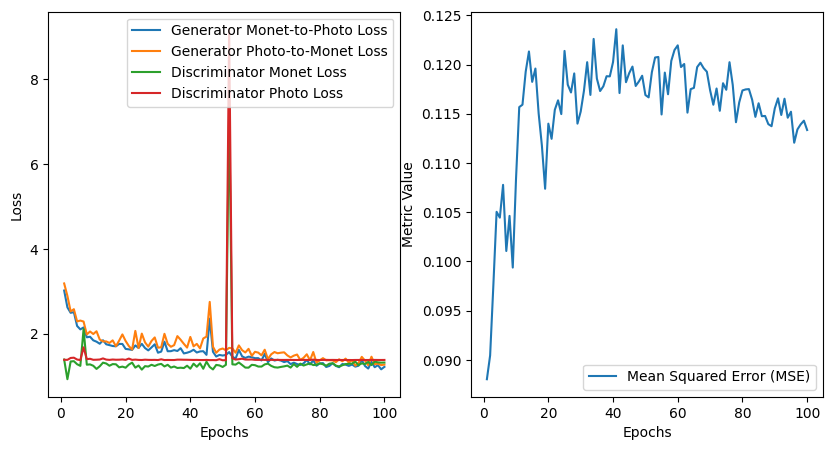

In [ ]:
# Plot epoch vs loss and epoch vs accuracy graphs
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, gen_monet_to_photo_losses, label='Generator Monet-to-Photo Loss')
plt.plot(epochs, gen_photo_to_monet_losses, label='Generator Photo-to-Monet Loss')
plt.plot(epochs, disc_monet_losses, label='Discriminator Monet Loss')
plt.plot(epochs, disc_photo_losses,  label='Discriminator Photo Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, mse_values, label='Mean Squared Error (MSE)')

plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()

plt.show()

**Testing of the MODEL**

In [ ]:
 num_samples = 5
 test_sample_paths = random.sample(photo,  num_samples)

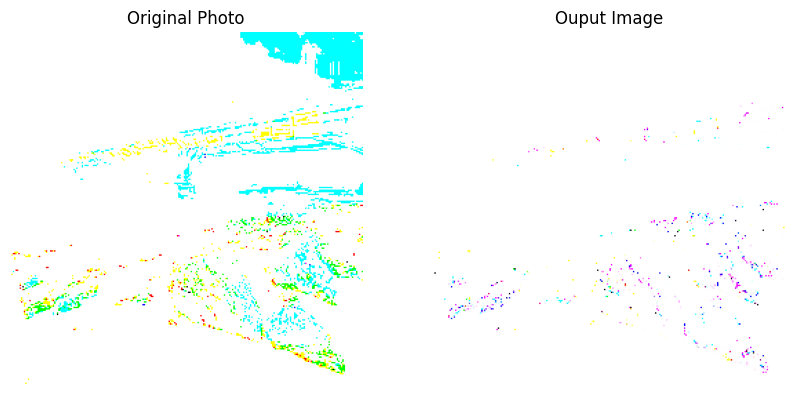

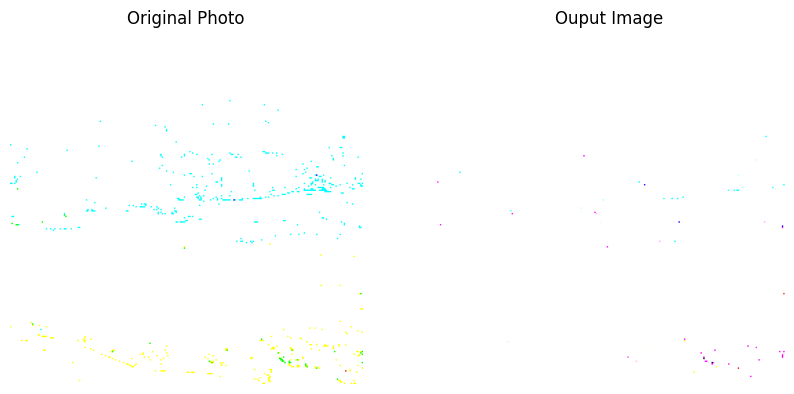

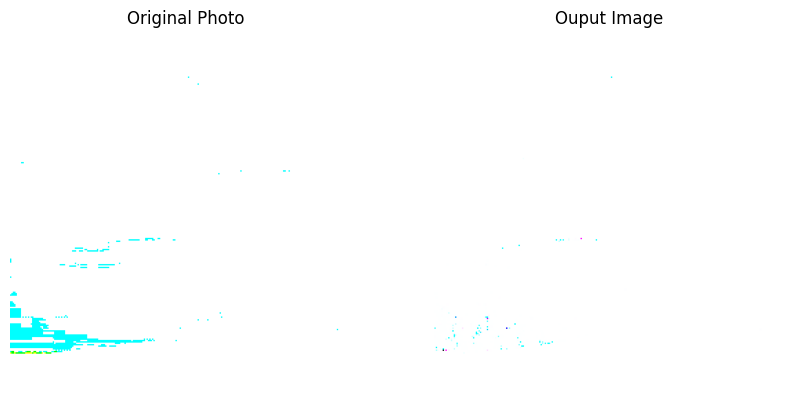

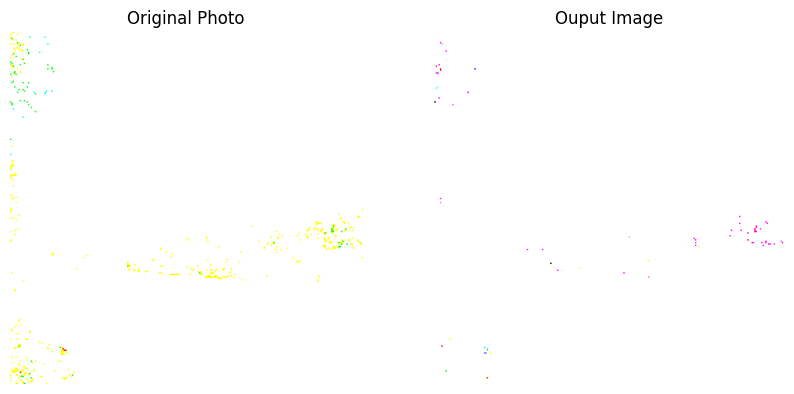

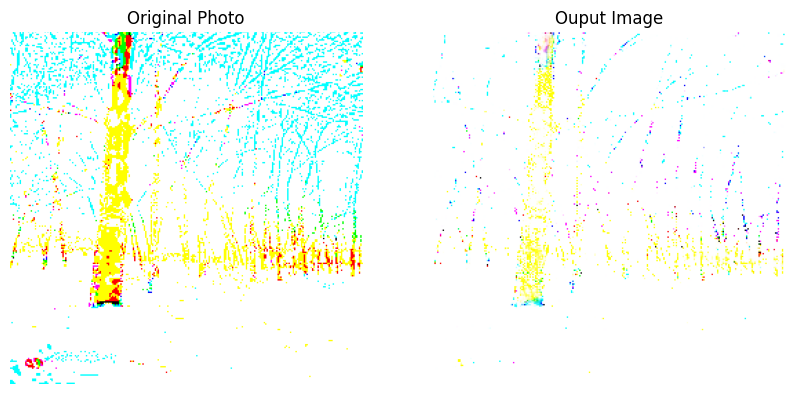

In [ ]:
for idx, photo in enumerate(test_sample_paths):
  # Load the image from the file path and convert it to a tensor
    photo = tf.io.read_file(photo)
    photo = tf.image.decode_jpeg(photo, channels=3)
    photo = tf.image.resize(photo, [256, 256])
    # Translate the photo to Monet style using the generator model
    generated_monet = cycle_gan.generate_photo_to_monet(photo[tf.newaxis, ...])

    # Convert the tensor to numpy array for plotting
    #generated_monet = generated_monet[0].numpy()

    # Convert the tensor to RGB image for plotting
    generated_monet = tf.keras.preprocessing.image.array_to_img(generated_monet[0])

    # Display the original photo and the generated image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Photo")
    plt.imshow(photo)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Ouput Image")
    plt.imshow(generated_monet)
    plt.axis("off")

    plt.show()